# Further training for citation sentence classifier

This notebooks attempts to incrementally refine a classifier for detecting sentences that require references to validate whether or not it is worth trying to improve it by trainign on more data (which is available, but would take a long time).

The general approach will be: train on new data, validate on a separate dataset, repeat; then check how the model's predictions evolved with each incrementation.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [3]:
import io
import os
import torch
import pandas as pd
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )

from torch.optim import AdamW


# Set seed for reproducibility,
set_seed(123)

epochs = 1
batch_size = 64
max_length = 512

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
model_name_or_path = '/content/drive/MyDrive/citing_sentence_classifier'

# Dicitonary of labels and their id - this will be used to convert.
# String labels to number.
labels_ids = {False: 0, True: 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [4]:
def filter_dataset(df: pd.DataFrame) -> pd.DataFrame:
  # drop na
  df = df.dropna()
  # remove any rows that have "<figure>" or "<formula>" on the `sentence` column
  df = df[~df['sentence'].str.contains('<figure>|<formula>')]

  # return shuffled version
  return df.sample(frac=1).reset_index(drop=True)

def construct_dataset(df: pd.DataFrame, n: int=10000) -> pd.DataFrame:
  return df.sample(n=n)

class PaperSentencesDataset(Dataset):
    def __init__(self, path, use_tokenizer, n = 10000, max_sequence_len=None):
        if not os.path.isfile(path):
            raise ValueError('Invalid `path` variable! Needs to be a file')

        self.use_tokenizer = use_tokenizer
        self.max_sequence_len = max_sequence_len or use_tokenizer.model_max_length

        df = pd.read_parquet(path, engine="pyarrow")
        df = filter_dataset(df)
        df = construct_dataset(df, n = n)
        self.texts = df['sentence'].tolist()
        self.labels = torch.tensor(df['citing'].tolist(), dtype=torch.long)

        self.n_examples = len(self.labels)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, idx):
        encoding = self.use_tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            truncation=True,
            padding="max_length",
            return_tensors='pt',
            max_length=self.max_sequence_len
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": self.labels[idx]
        }


def collate_fn(batch):
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    labels = torch.stack([item["labels"] for item in batch])

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}


def train(dataloader, optimizer_, scheduler_, device_):
    global model
    model.train()
    predictions_labels = []
    true_labels = []
    total_loss = 0

    scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training

    for batch in tqdm(dataloader, total=len(dataloader)):
        true_labels += batch['labels'].cpu().numpy().flatten().tolist()
        batch = {k: v.to(device_) for k, v in batch.items()}

        optimizer_.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(**batch)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer_)
        scaler.update()
        scheduler_.step()

        total_loss += loss.item()
        logits = outputs.logits.detach().cpu().numpy()
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss


def validation(dataloader, device_):
    global model
    model.eval()
    predictions_labels = []
    true_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, total=len(dataloader)):
            true_labels += batch['labels'].cpu().numpy().flatten().tolist()
            batch = {k: v.to(device_) for k, v in batch.items()}

            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            logits = outputs.logits.detach().cpu().numpy()
            predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    avg_epoch_loss = total_loss / len(dataloader)
    return true_labels, predictions_labels, avg_epoch_loss

In [5]:
# Ge t model configuration.
print('Loading configuraiton...')
model_config = AutoConfig.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                          num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

# Get the actual model.
print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path,
                                                           config=model_config)

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...
Model loaded to `cuda`


## Data

We'll be using some unused data from the initial dataset we trained on, building 10 dataloaders of 10k samples for each incremental run and a validation dataset.

In [6]:
train_dataset = PaperSentencesDataset(path='/content/drive/MyDrive/citing_sentence_dataset/citing_test.parquet',
                               n = 100000,
                               use_tokenizer=tokenizer,
                               max_sequence_len=max_length)

# create 10 dataloaders, splitting the dataset in ten
dataloaders = []

# Creating subsets of the dataset using dataset.n_examples to get accurate lengths
subset_size = train_dataset.n_examples // 10

for i in range(10):
  # Adjust indexing to use subset_size to ensure correct ranges
  start_idx = i * subset_size
  end_idx = (i + 1) * subset_size if i < 9 else train_dataset.n_examples # Handle the last subset
  dataloaders.append(DataLoader(torch.utils.data.Subset(train_dataset, range(start_idx, end_idx)),
                                batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=8, pin_memory=True))

val_dataset = PaperSentencesDataset(path='/content/drive/MyDrive/citing_sentence_dataset/citing_val.parquet',
                               use_tokenizer=tokenizer,
                               max_sequence_len=max_length)

val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8, pin_memory=True)


## Training

After training on each step, we'll be evaluating the model on the validation dataset and saving the result each time so we can track the model's evolution after each step.

  0%|          | 0/10 [00:00<?, ?it/s]


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.11861 - val_loss: 0.12308 - train_acc: 0.96330 - valid_acc: 0.95930


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.11784 - val_loss: 0.12938 - train_acc: 0.96300 - valid_acc: 0.95800


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.12641 - val_loss: 0.12388 - train_acc: 0.95930 - valid_acc: 0.95750


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.12441 - val_loss: 0.12533 - train_acc: 0.96220 - valid_acc: 0.95830


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.12534 - val_loss: 0.12723 - train_acc: 0.96020 - valid_acc: 0.95820


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.12036 - val_loss: 0.12445 - train_acc: 0.96170 - valid_acc: 0.95760


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.11442 - val_loss: 0.12267 - train_acc: 0.96470 - valid_acc: 0.95840


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.12072 - val_loss: 0.12132 - train_acc: 0.96030 - valid_acc: 0.95860


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.11716 - val_loss: 0.12063 - train_acc: 0.96170 - valid_acc: 0.95930


Training on batches...


<ipython-input-4-fd54e543ad0a>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Enable mixed precision training


  0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-4-fd54e543ad0a>:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation on batches...


  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.10685 - val_loss: 0.12055 - train_acc: 0.96520 - valid_acc: 0.95840



/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


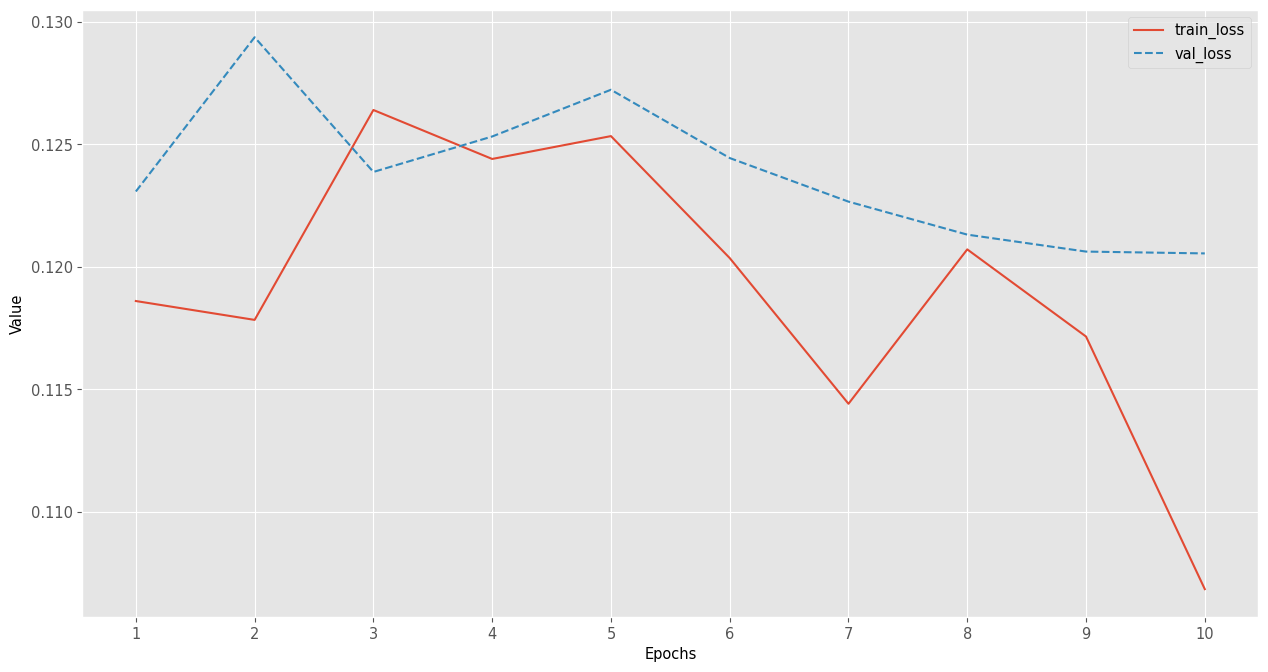

/usr/local/lib/python3.11/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


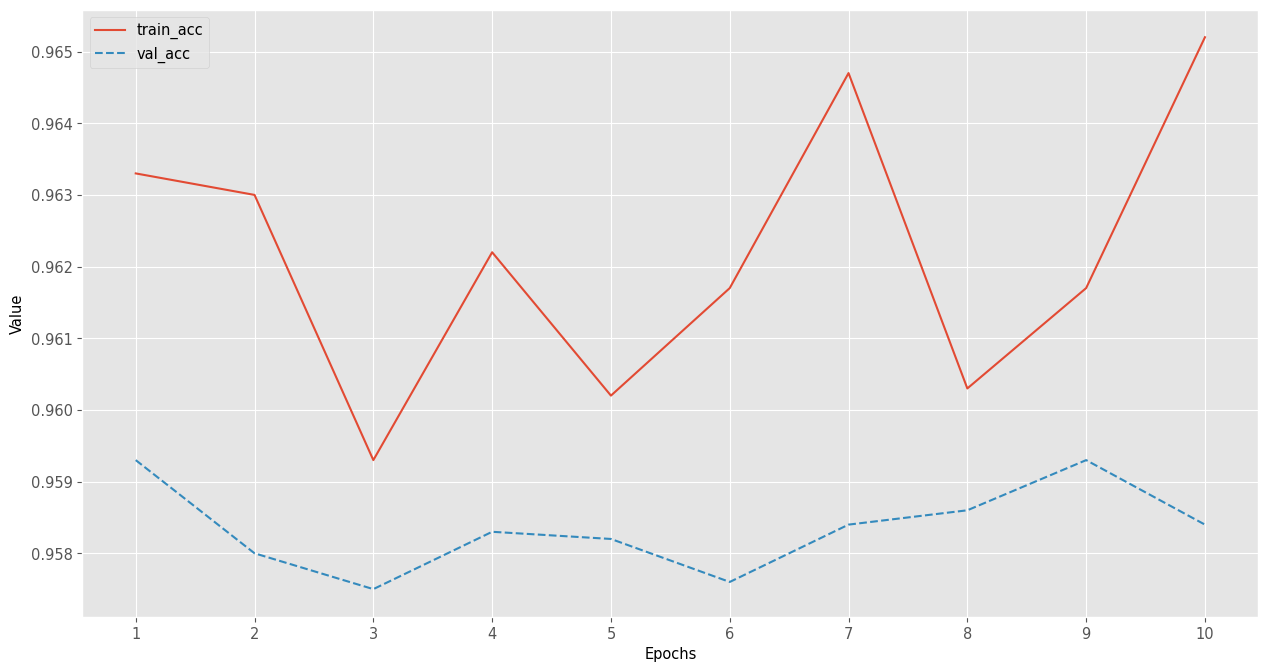

In [7]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.

total_steps = sum(len(dataloader) for dataloader in dataloaders)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
for train_dataloader in tqdm(dataloaders):
  print()
  print('Training on batches...')
  # Grab 10000 samples from dataloader

  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data.
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss = validation(val_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

## Evaluation

It seems that for the most part the model doesn't change much inbetween runs, leading to the conclusion that further training won't improve the model much.

If we want to see improvements, we might be more inclined to try different approaches, such as:

* using a different model (e.g: a proper LLM)
* using different data (e.g: a smaller, but more refined dataset)
* formulating the problem differently (maybe taking into account previous sentences?)

In [8]:
valid_labels, valid_predict, val_loss = validation(val_dataloader, device)
val_acc = accuracy_score(valid_labels, valid_predict)

# Print loss and accuracy values to see how training evolves.
print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
print()

# confusion matrix
print(classification_report(valid_labels, valid_predict, target_names=['not citing', 'citing']))

  0%|          | 0/157 [00:00<?, ?it/s]

  train_loss: 0.10685 - val_loss: 0.12055 - train_acc: 0.96520 - valid_acc: 0.95840

              precision    recall  f1-score   support

  not citing       0.96      0.99      0.98      9229
      citing       0.84      0.56      0.68       771

    accuracy                           0.96     10000
   macro avg       0.90      0.78      0.83     10000
weighted avg       0.96      0.96      0.95     10000



Normalized confusion matrix


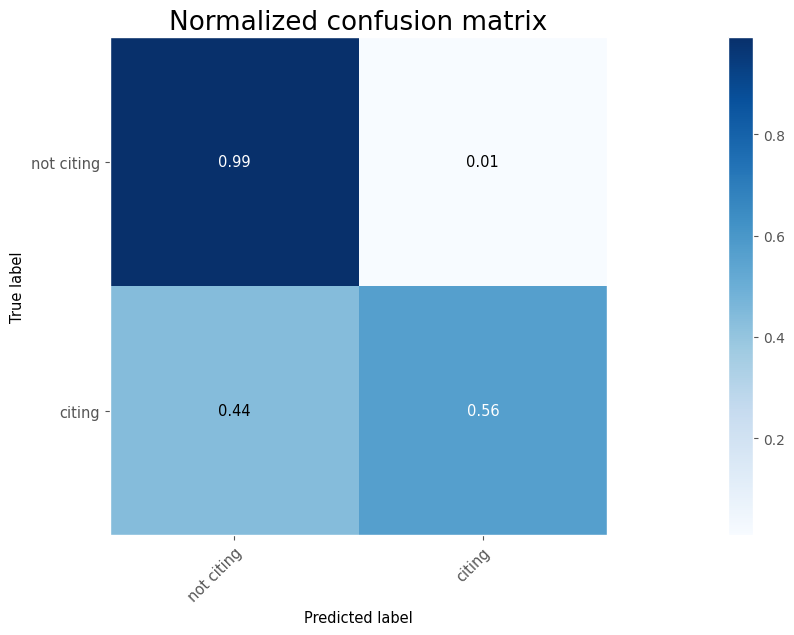

array([[0.99133167, 0.00866833],
       [0.43579767, 0.56420233]])

In [9]:
plot_confusion_matrix(y_true=valid_labels, y_pred=valid_predict, classes=['not citing', 'citing'], normalize=True)